# tenor basis swap
Mark to market value of 3M-6M tenor basis swap of JPY is given by

$
\begin{align}
V_{ts}(t) &= V_{\text{6M}} - V_{\text{3M}} \\
            &= \Sigma_{i = 1}^{n^{6M}} D^{6M}(t^{6M}_{i}) L^{6M}(t, t^{6M}_{i-1}, t^{6M}_{i}) \delta^{6M}_{t^{6M}_{i}}
            - \Sigma_{j = 1}^{n^{3M}} D^{3M}(t^{3M}_{j}) \left(L^{3M}(t, t^{3M}_{j-1}, t^{3M}_{j}) + \alpha^{6-3}_{t, n^{3M}} \right) \delta^{3M}_{t^{3M}_{j}} \\
            &= \left( D^{6M}(t^{6M}_{0}) - D^{6M}(t^{6M}_{n^{6M}})\right) - 
            \Sigma_{j = 1}^{n^{3M}} D^{3M}(t^{3M}_{j}) \left(L^{3M}(t, t^{3M}_{j-1}, t^{3M}_{j}) + \alpha^{6-3}_{t, n^{3M}} \right)
\end{align}
$

where $\alpha^{6-3}_{t, n^{3M}}$ is a tenor basis spread with matuiry of corresponding tenor basis swap. This notation is the same as $\alpha^{6-3}_{t, n^{6M}}$ because both cash flows will finish at the same time on maturity.

$
L^{3M}(t, t_{i-1}, t_{i}) = \frac{
\left( D^{6M}(t^{6M}_{0}) - D^{6M}(t^{6M}_{N}) \right)
- \Sigma_{i}^{M - 1} D(t^{3M}_{i - 1}) \left( L^{3M}(t, t^{3M}_{i-2}, t^{3M}_{i-1}) + \alpha^{3-6}_{M} \right) \delta^{3M}
}
{D(t^{3M}_{i}) \delta^{3M}} - \alpha^{3-6}_{M}
$

In [1]:
import pandas as pd
import numpy as np
from  single_df_curve import single_df_curve
import os
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
input_path = '/Users/susynishida/Desktop/dev/Python/Finance/input/20180731'
file_name = 'TenorBasis.csv'
file_path = os.path.join(input_path, file_name)

In [3]:
df_tb = pd.read_csv(file_path)
df_tb.head()

,date,item,ccy,tenor,maturity,spread
0,2018/7/31,TenorBasis,JPY,3M,1Y,-0.008
1,2018/7/31,TenorBasis,JPY,3M,2Y,-0.009
2,2018/7/31,TenorBasis,JPY,3M,3Y,-0.010
3,2018/7/31,TenorBasis,JPY,3M,4Y,-0.010
4,2018/7/31,TenorBasis,JPY,3M,5Y,-0.010


In [30]:
class TenorBasis():
    def __init__(self, df, str_ccy):
        self._df = df[df['ccy'] == str_ccy]
        self._ccy = str_ccy
        self._str_tenor = (self._df['tenor'].unique())[0]
        self._int_tenor_m = int((self._str_tenor)[:-1])
        self._float_tenor_y = (self._int_tenor_m) / 12
        self._int_max_mat = int((self._df.iloc[-1]['maturity'])[:-1])
        
    def add_col_mat_interp(self):
        df_add_col = (self._df).copy()
        df_add_col['flo_mat_for_intep'] = df_add_col['maturity'].apply(lambda x: float(x[:-1]))
        return df_add_col
        
    def gen_maturity(self):
        maturity_list = np.arange(0, self._int_max_mat + self._float_tenor_y, self._float_tenor_y)
        return maturity_list
    
    def gen_df_for_interp(self):
        df_maturity = pd.DataFrame(self.gen_maturity(), columns=['maturity_for_interp'])
        df_add_col = self.add_col_mat_interp()
        df_for_intep = pd.merge(df_maturity, df_add_col, left_on='maturity_for_interp', right_on='flo_mat_for_intep', how='outer')
        return df_for_intep
    
    def interp_spread(self):
        df_for_intep = self.gen_df_for_interp()
        df_for_intep.iloc[0] = 0
        df_interp = (df_for_intep.set_index('maturity_for_interp')[['spread']]).interpolate('index')
        return df_interp
    
    def get_test(self):
        return self.interp_spread()

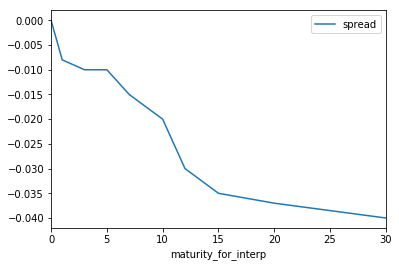

In [5]:
tb = TenorBasis(df_tb, 'JPY')
tb.interp_spread().plot()

In [15]:
tb = TenorBasis(df_tb, 'JPY')
tb.get_test().head()

,spread
maturity_for_interp,
0.00,0.000
0.25,-0.002
0.50,-0.004
0.75,-0.006
1.00,-0.008


In [14]:
tb = TenorBasis(df_tb, 'JPY')
tb.gen_df_for_interp().set_index('maturity_for_interp')[['spread']].interpolate('index', limit_direction='both').head()

,spread
maturity_for_interp,
0.00,-0.008
0.25,-0.008
0.50,-0.008
0.75,-0.008
1.00,-0.008


In [8]:
base_date = '20180731'
root_path = '/Users/susynishida/Desktop/dev/Python/Finance/input/'
file_name = '/IR.csv'
file_path = os.path.join(root_path + base_date + file_name)
df_IR = pd.read_csv(file_path)

In [9]:
DF_obj = single_df_curve.discount_factor(df_IR, 'USD')
df_DF_20180731 = pd.DataFrame(DF_obj.get_array_DF('2018/08/02', '2048/7/15', 'cubic', 'cubic'), columns=['date', 'DF'])

In [10]:
df_DF_20180731['date'] = pd.to_datetime(df_DF_20180731['date'])
df_DF_20180731.set_index('date', inplace=True)

In [31]:
initial_float_rate = DF_obj.get_raw_rate('3M')

In [236]:
index_datetime = pd.date_range(start='20180702', end='20480702')
index_datetime

DatetimeIndex(['2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05',
               '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09',
               '2018-07-10', '2018-07-11',
               ...
               '2048-06-23', '2048-06-24', '2048-06-25', '2048-06-26',
               '2048-06-27', '2048-06-28', '2048-06-29', '2048-06-30',
               '2048-07-01', '2048-07-02'],
              dtype='datetime64[ns]', length=10959, freq='D')

In [71]:
index_datetime[(index_datetime.day == 2) & index_datetime.month.isin([8, 11, 2, 5])]

DatetimeIndex(['2018-08-02', '2018-11-02', '2019-02-02', '2019-05-02',
               '2019-08-02', '2019-11-02', '2020-02-02', '2020-05-02',
               '2020-08-02', '2020-11-02',
               ...
               '2046-02-02', '2046-05-02', '2046-08-02', '2046-11-02',
               '2047-02-02', '2047-05-02', '2047-08-02', '2047-11-02',
               '2048-02-02', '2048-05-02'],
              dtype='datetime64[ns]', length=120, freq=None)

In [277]:
def generate_cash_flow_month_list(initial_date, end_date, freq_month):
    """
    input: start date, maturity date, frequency of month
    output: a list of month of corresponding frequency (type is integer)
    """
    num_month = datetime.datetime.strptime(initial_date, '%Y/%m/%d').month
    month_list = [num_month]
    int_freq_month = int(freq_month[:-1])
    len_iteration = int(12 / int_freq_month)
    for i in range(len_iteration - 1):
        num_month += int_freq_month
        if num_month > 12:
            num_month -= 12
        else:
            pass
        month_list.append(num_month)
    return month_list

def generate_cash_flow_month(initial_date, end_date, freq_month, roll_date):
    """
    return datetime dataframe with designated roll_date and a list of month of corresponding frequency
    """
    cashflow_list = generate_cash_flow_month_list(initial_date, end_date, freq_month)
    df_tmp = pd.date_range(start=initial_date, end=end_date)
    df_dt = df_tmp[(df_tmp.day == roll_date) & (df_tmp.month.isin(cashflow_list))]
    return df_dt

In [263]:
generate_cash_flow_month_list('2018/7/2', '2048/7/2', '3M')
generate_cash_flow_month('2018/7/2', '2048/7/2', '3M', 2)

DatetimeIndex(['2018-07-02', '2018-10-02', '2019-01-02', '2019-04-02',
               '2019-07-02', '2019-10-02', '2020-01-02', '2020-04-02',
               '2020-07-02', '2020-10-02',
               ...
               '2046-04-02', '2046-07-02', '2046-10-02', '2047-01-02',
               '2047-04-02', '2047-07-02', '2047-10-02', '2048-01-02',
               '2048-04-02', '2048-07-02'],
              dtype='datetime64[ns]', length=121, freq=None)

In [273]:
df_test = pd.DataFrame(generate_cash_flow_month('2018/7/2', '2048/7/2', '3M', 2)).set_index([0])
df_test.head(30)

""
0
2018-07-02
2018-10-02
2019-01-02
2019-04-02
2019-07-02
2019-10-02
2020-01-02
2020-04-02
2020-07-02


## trial space

In [78]:
df = pd.DataFrame({'N1': [1, 2, 3, 4, 5, 6],
                   'N2': [10, 20, 30, 40, 50, 60],
                   'N3': [6, 5, 4, 3, 2, 1],
                   'F1': [1.1, 2.2, 3.3, 4.4, 5.5, 6.6],
                   'F2': [1.1, 2.2, 3.3, 4.4, 5.5, 6.6],
                   'S1': ['A', 'b', 'C', 'D', 'E', 'F'],
                   'S2': ['A', 'X', 'X', 'X', 'E', 'F'],
                   'D1': pd.date_range('2014-11-01', freq='D', periods=6)})
df

,D1,F1,F2,N1,N2,N3,S1,S2
0,2014-11-01,1.1,1.1,1,10,6,A,A
1,2014-11-02,2.2,2.2,2,20,5,b,X
2,2014-11-03,3.3,3.3,3,30,4,C,X
3,2014-11-04,4.4,4.4,4,40,3,D,X
4,2014-11-05,5.5,5.5,5,50,2,E,E
5,2014-11-06,6.6,6.6,6,60,1,F,F


In [105]:
df_test = pd.DataFrame({'a': [1,2], 'b': [3,4], 'date': ['20180731', '20180930']})
df_test

,a,b,date
0,1,3,20180731
1,2,4,20180930


In [113]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.set_index('date')

,a,b
date,,
2018-07-31,1,3
2018-09-30,2,4


In [119]:
df_test_2 = pd.DataFrame(np.random.randn(10,2))
df_test_2

,0,1
0,0.711072,0.734881
1,-0.037444,0.704516
2,-0.307548,-0.312760
3,-1.370722,0.837124
4,1.678157,0.650706
5,-0.740335,1.424259
6,1.054841,-0.371938
7,-1.100815,-0.351681
8,0.730635,0.244518
9,0.054926,2.176498


In [124]:
pd.DataFrame({'a': [1, 2], 'b': [3, 4]})

,a,b
0,1,3
1,2,4


In [127]:
sr1 = pd.Series([1, 2, 3, 4])
sr2 = pd.Series([5, 6, 7, 8])